# **Etude des différents types de maintenance**

Le but ici est d'étudier toutes les colonnes traitant de la maintenance pour pouvoir réduire cela en une seule colonne qui va nous servir pour la formule finale du score ETIC. Au début, nous pensions qu'une ACM pouvait nous permettre de catégoriser et savoir quelles colonnes avaient le plus de poids pour accorder un score pour la maintenance. Quand nous avons essayé de faire cela, nous n'avons pu aboutir à aucun résultat car même en ayant le résultat de l'ACM nous n'avons pas pu avancer et cela ne nous a pas aidé. Ensuite, nous avons eu l'idée de faire de la classification non supervisée pour pouvoir accorder à chaque établissement une valeur sans connaître à l'avance les caractéristiques d'une classe.

Ici, nous allons étudier toutes les colonnes qui ont un lien avec la maintenance du matériel informatique, donc les colonnes suivantes : 
- *``'Maint_PersCollect'``* : la maintenance est faire par du personnel de la collectivité
- *``'Maint_PrestaExt'``* : la maintenance est faite par des prestataires extérieures
- *``'Maint_PersonnelEducNatHsEtab'``* : la maintenance est faite par du personnel de l'éducation nationale hors établissement
- *``'Maint_PersonnelEtab'``* : la maintenance est faite par le personnel de l'établissement
- *``'Maint_AutreNeSaitPas'``* : soit la maintenance est faite par quelqu'un d'autre ou l'établissement ne sait pas
- *``'Maint_Personne'``* : personne ne fait la maintenance



### *Import des bibliothèques*

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly_express as px
import plotly.graph_objects as go

# import image module
from IPython.display import Image
import kaleido
import io
from PIL import Image as ImagePIL

### *Import du fichier*

In [3]:
df = pd.read_csv('../data/lycee-college/fr-en-etic_2d.csv', sep=';')

#on garde les données les plus récentes, donc 2019
df = df.loc[df["Millesime"] == 2019]

#On fixe l'index
df.set_index('Code_UAI', inplace=True)

#On consulte les colonnes existantes
df.columns

Index(['Millesime', 'Code_nature', 'nature_uai', 'typ_etab', 'Academie',
       'Departement', 'NbEleve', 'NbEnseignant', 'SiEtabCentreRessource',
       'SiProjetNumEcole', 'SiEntDisponible', 'SiProjEtabIntegreENT',
       'Maint_PersCollect', 'Maint_PrestaExt', 'Maint_PersonnelEducNatHsEtab',
       'Maint_PersonnelEtab', 'Maint_AutreNeSaitPas', 'Maint_Personne',
       'NbRessourceEdit', 'TpRess_ManuelNum', 'TpRess_AnimScienLogiSimu',
       'TpRess_Bdd', 'TpRess_LogiOutils', 'TpRess_OuvRef',
       'TpRess_ResEntrainement', 'TpRess_Autres', 'TpRess_aucune',
       'ServInt_NoteElev', 'ServInt_AbsElev', 'ServInt_EdtElevCls',
       'ServInt_CahierTxt', 'ServInt_DocRessPeda', 'ServInt_AgdActuEtab',
       'ServInt_PlatApp', 'ServInt_Autres', 'ServInt_aucun', 'NbTerminaux',
       'NbTablette', 'NbTablettePC', 'NbMicroMoins5', 'NbMicroPortable',
       'NbPortAffEl', 'NbPortAffEns', 'NbEleveEqASH', 'NbPosteEqASH', 'NbTBI',
       'propClassesAvecTBI', 'NbVideoProj', 'NbClassMobile', '

On va maintenant récupérer les colonnes qui nous intéressent et supprimer celles qui ne nous intéressent pas. Nous allons ensuite supprimer les lignes qui contiennent des `NaN` pour pouvoir procéder à nos analyses.


In [4]:
#Suppression des colonnes inutiles
df_maintenance = df.drop(columns=[ 'Millesime', 'Code_nature', 'nature_uai', 'typ_etab',
       'Academie', 'Departement', 'NbEleve', 'NbEnseignant',
       'SiEtabCentreRessource', 'SiProjetNumEcole', 'SiEntDisponible',
       'SiProjEtabIntegreENT', 'NbRessourceEdit',
       'TpRess_ManuelNum', 'TpRess_AnimScienLogiSimu', 'TpRess_Bdd',
       'TpRess_LogiOutils', 'TpRess_OuvRef', 'TpRess_ResEntrainement',
       'TpRess_Autres', 'TpRess_aucune', 'ServInt_NoteElev', 'ServInt_AbsElev',
       'ServInt_EdtElevCls', 'ServInt_CahierTxt', 'ServInt_DocRessPeda',
       'ServInt_AgdActuEtab', 'ServInt_PlatApp', 'ServInt_Autres',
       'ServInt_aucun', 'NbTerminaux', 'NbTablette', 'NbTablettePC',
       'NbMicroMoins5', 'NbMicroPortable', 'NbPortAffEl', 'NbPortAffEns',
       'NbEleveEqASH', 'NbPosteEqASH', 'NbTBI', 'propClassesAvecTBI',
       'NbVideoProj', 'NbClassMobile', 'NbLecteurMpx', 'NbImpr3D',
       'AccWeb_RTC', 'AccWeb_CableFibreOptique', 'AccWeb_ADSL',
       'AccWeb_AutresHautDebit', 'AccWeb_NeSaitPas', 'AccWeb_Aucun',
       'DebitWeb', 'SiWifi', 'SalleInternet', 'PostesInfoElvHorsCours',
       'SiPareFeuEtab', 'SiOuifiltrageWeb', 'ControlePosteriori',
       'SiCharteUsageWeb', 'Diffch_AnnexeeRI',
       'Diffch_DossierRentreeEnseignants', 'Diffch_CRConseilAdmin',
       'Diffch_DiffusionParents', 'Diffch_Autres', 'AccesParentCharte',
       'ElvAuthentif', 'SiVisioConferenc', 'SiEntUtilise',
       'TypeMatHandi_Tablette', 'TypeMatHandi_OrdiPort', 'TypeMatHandi_LogApp',
       'TypeMatHandi_Autre', 'Code_region', 'Libelle_region'], inplace=False)


df_maintenance.dropna(inplace=True, axis=0)

In [5]:
#on vérifie que les colonnes ont bien été supprimées
df_maintenance.columns

Index(['Maint_PersCollect', 'Maint_PrestaExt', 'Maint_PersonnelEducNatHsEtab',
       'Maint_PersonnelEtab', 'Maint_AutreNeSaitPas', 'Maint_Personne'],
      dtype='object')

On va ensuite procéder au renommage des colonnes pour pouvoir manipuler les données plus facilement et éviter d'avoir des noms de colonnes trop longs.

In [6]:
for col in df_maintenance.columns:
    df_maintenance.rename(columns={col: col.replace('Maint_', '').lower()}, inplace=True)

df_maintenance.columns

Index(['perscollect', 'prestaext', 'personneleducnathsetab', 'personneletab',
       'autrenesaitpas', 'personne'],
      dtype='object')

### *Corrélation entre les variables*

Nous allons voir si il existe des corrélations entre nos différentes variables, pour cela nous devons transformer les valeurs de nos colonnes en valeurs binaires. On va remplacer "oui" par 1 et "non" par 0.

In [7]:
for col in df_maintenance.columns:
    df_maintenance.replace({"oui": "1", "non": "0"}, inplace=True)
    df_maintenance[col] = df_maintenance[col].astype('float64')

df_maintenance.head()

,perscollect,prestaext,personneleducnathsetab,personneletab,autrenesaitpas,personne
Code_UAI,,,,,,
0810016C,1.0,0.0,0.0,1.0,0.0,0.0
0810026N,1.0,0.0,0.0,1.0,0.0,0.0
0810041E,0.0,0.0,0.0,1.0,0.0,0.0
0810125W,1.0,0.0,0.0,1.0,0.0,0.0
0811144D,1.0,0.0,0.0,1.0,0.0,0.0


On va maintenant créer la matrice de corrélation pour chercher les liens.

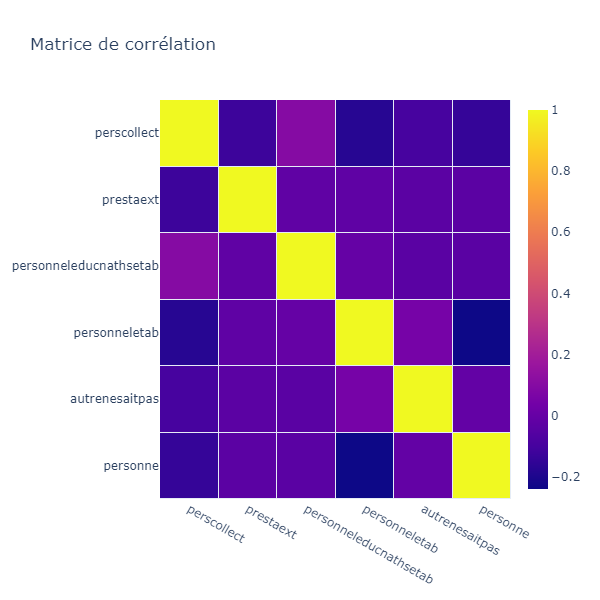

In [8]:
column_names = df_maintenance.columns

heat = go.Heatmap(
    z=df_maintenance.corr(),
    x=column_names,
    y=column_names,
    xgap=1,
    ygap=1,
    colorbar_thickness=20,
    colorbar_ticklen=3,
    hovertext=df_maintenance.corr(),
    hoverinfo='text'
)

layout = go.Layout(
    title='Matrice de corrélation',
    width=600,
    height=600,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig = go.Figure(data=[heat], layout=layout)
Image(fig.to_image(format="png", engine="kaleido", width=600, height=600))

#fig.show()

On voit qu'il n'existe pas réellement de corrélation entre les différentes variables. On s'y attend car en général il y a une seule personne qui s'occupe de l'entretien.

### *Classification non supervisé*

On va pouvoir maintenant faire du clustering à l'aide de l'algorithme de `KMeans`.

In [9]:
km_maintenance = KMeans(
    n_clusters=4, 
    random_state=0,
    init='k-means++',
    n_init=20,
    max_iter=300
)

y_km_maintenance = km_maintenance.fit_predict(df_maintenance)

resultat = pd.DataFrame(km_maintenance.cluster_centers_, columns=km_maintenance.feature_names_in_)

resultat

,perscollect,prestaext,personneleducnathsetab,personneletab,autrenesaitpas,personne
0,-4.440892e-16,0.142857,6.493506e-02,9.285714e-01,2.597403e-02,3.246753e-02
1,1.000000e+00,0.067039,-1.804112e-16,1.000000e+00,5.586592e-03,-1.214306e-17
2,9.512195e-01,0.097561,1.000000e+00,7.804878e-01,-5.204170e-18,-5.204170e-18
3,1.000000e+00,0.037736,5.551115e-17,-1.110223e-16,-5.204170e-18,-5.204170e-18


On va convertir cela en "oui" et "non" pour que nous puissions juger simplement les moyennes des centres et choisir le nombre de clusters souhaités.

In [10]:
def change_value(row):
    if(row > 0.5):
        return 1        
    else:
        return 0


for col in resultat.columns:
    resultat[col] = resultat[col].apply(change_value)
    resultat[col] = resultat[col].astype(str)
    resultat.replace({"1": "oui", "0" : "non"}, inplace=True)

resultat

,perscollect,prestaext,personneleducnathsetab,personneletab,autrenesaitpas,personne
0,non,non,non,oui,non,non
1,oui,non,non,oui,non,non
2,oui,non,oui,oui,non,non
3,oui,non,non,non,non,non


Nous pouvons donc voir qu'il existera 4 modalités, une chaque pour classe. Nous allons donc créer une colonne avec les 4 modalités suivantes pour une colonne maintenance :
- "Trés bien" : classe 0 (c'est la classe avec le plus de "oui" en moyenne, il y a donc une trés bonne maintenance de l'équipement numérique)
- "Bien" : classe 1  (cette classe a pour moyenne en maintenance 2 "oui", il y a donc deux moyens de maintenance diversifiés qui peut garantir une bonne qualité de maintenance)
- "Assez bien" : classe 2  (pour cette classe, on a en moyenne seulement du personnel de l'établissement qui effectue des maintenances. Comme ce personnel est attaché directement à l'établissement, il peut agir plus rapidement et efficacement sur le terrain. L'établissement peut rapidement le solliciter pour une intervention rapide)
- "Moyen" : classe 3  (cette classe n'a qu'un seul "oui" en moyenne, la maintenance est faite par du personnel de la collectivité. Ce personnel peut réagir moins rapidement mais il peut être géré simplement par la collectivité compétente)

In [11]:
df_maintenance['cluster'] = y_km_maintenance
df_maintenance['cluster'] = df_maintenance['cluster'].astype(str)

df_maintenance.replace({"0": "Trés bien", "1" : "Bien", "2" : "Assez bien", "3" : "Moyen"}, inplace=True)

df_maintenance.head()

,perscollect,prestaext,personneleducnathsetab,personneletab,autrenesaitpas,personne,cluster
Code_UAI,,,,,,,
0810016C,1.0,0.0,0.0,1.0,0.0,0.0,Bien
0810026N,1.0,0.0,0.0,1.0,0.0,0.0,Bien
0810041E,0.0,0.0,0.0,1.0,0.0,0.0,Trés bien
0810125W,1.0,0.0,0.0,1.0,0.0,0.0,Bien
0811144D,1.0,0.0,0.0,1.0,0.0,0.0,Bien


### *ACP* 

Nous pouvons maintenant passer à l'ACP pour voir les groupes d'individus (établissements) existants et voir si l'affectation est bien faite ou pas.

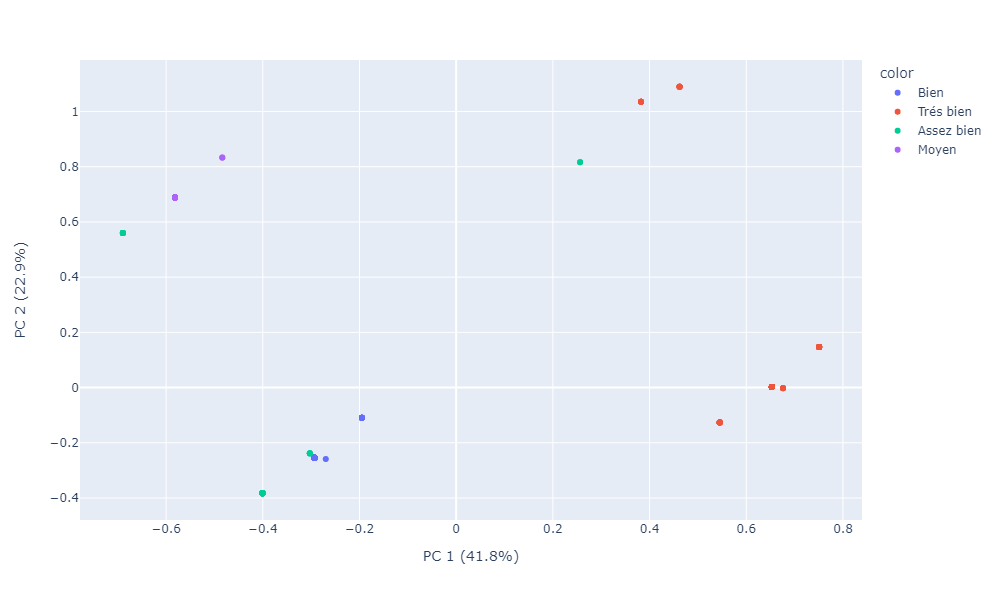

In [14]:
pca_maint = PCA(n_components=2)

components_maint = pca_maint.fit_transform(df_maintenance.drop(columns=['cluster']))

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca_maint.explained_variance_ratio_ * 100)
}

fig = px.scatter(components_maint, x=0, y=1, color=df_maintenance['cluster'], labels=labels)
Image(fig.to_image(format="png", engine="kaleido", width=1000, height=600))

#fig.show()

On remarque que la variance totale expliquée ici est de 65.5 %. On voit qu'il existe 4 groupes d'individus. Le seul moyen de bien partager les individus est de passer à 2 clusters. Seul soucis c'est que cela ne nous aide pas pour mettre en place différentes appréciations pour la maintenance en général car les classes ont quasiment les mêmes centres. On va donc rester sur 4 clusters ici.


### *Enregistrement du résultat*

On peut maintenant donc passer à l'enregistrement du résultat dans un fichier ".csv".

In [13]:
df_maintenance_final = pd.DataFrame(df_maintenance.cluster)
df_maintenance_final.rename(columns={'cluster': 'maintenance'}, inplace=True)

df_maintenance_final.to_csv('../data/analyses/maintenance.csv', sep=';', index=True)